In [1]:
# import the necessary libraries
import numpy as np                  
import pandas as pd      
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error   

import nltk
## in case haven't download yet, only need to do once per run
# nltk.download('punkt')
# nltk.download('stopwords')

from nltk.corpus import stopwords
import string
from nltk.tokenize import word_tokenize
from collections import Counter

# Processing the data

In [2]:
# read the data from the file '5-Minute Crafts.csv'
df = pd.read_csv('5-Minute Crafts.csv')

# check by printing the first 5 data points
df.head(5)

,video_id,title,active_since_days,duration_seconds,total_views,num_chars,num_words,num_punctuation,num_words_uppercase,num_words_lowercase,num_stopwords,avg_word_len,contain_digits,startswith_digits,title_sentiment
0,v=XHTofu5wbbM,SUPER LAZY LIFE HACKS || Cool Hacks To Make Yo...,22,623,295614,60,12,2,4,0,2,5.000000,0,0,0.144444
1,v=HGxx0umIQvk,YUM! EASY SMART FOOD HACKS || Tasty Recipes Fo...,1,739,130544,87,17,4,5,0,3,5.117647,0,0,0.086905
2,v=Tt4RMk3Ih04,HELPFUL LIFE HACKS FOR YOUR HOUSE,1,960,17834,33,6,0,6,0,2,5.500000,0,0,0.000000
3,v=A2MTydM5e58,USEFUL HACKS FOR YOUR HOME || Simple Tips That...,30,833,3128867,66,12,2,5,0,3,5.500000,0,0,0.058333
4,v=_halJ4yrmGQ,ARE YOU A CRAFTY MOM? Amazing Parenting Hacks ...,15,3600,4210362,56,10,1,5,0,4,5.600000,0,0,0.500000


## Create relative rating column

From the column total_views, we will calculate the 'relative rating', a scale from 1-100 to indicate how well the video do as respect to the highest viewed video (refer to the report for more information).

In [3]:
maxViews = df["total_views"].max()
df = df.assign(relative_rating = df["total_views"] / maxViews * 100)

## Clean the video titles

Since the title is essentially just a list of words, we will try to turn it into such form for easier manipulation. We need to remove stop words, punctuation, capitalization, and other symbols from the title to get a sentence of clean text. Then, we tokenize the clean sentence into a list of words for later manipulation. We will make use of the NLTK library for this process.

In [4]:
# function to tokenize and clean a sentence
def tokenize_and_clean(x):
    # turn x into lower case
    x = x.lower()
    # tokenize x
    tokens = word_tokenize(x)
    
    # filter out the stop words
    clean_tokens = [word for word in tokens if not word in stopwords.words()]
    # filter out the punctuation
    clean_tokens = [word for word in clean_tokens if not word in string.punctuation]
    # filter out non-alphabetical words (numbers, special characters, etc), only leave normal words
    clean_tokens = list(filter(lambda token: token.isalpha() == True, clean_tokens))
    
    return clean_tokens

In [5]:
# apply the function to all titles in 'title' column, to create a new column 'clean_token'
# Note that this will take quite a long time to run
df['clean_token'] = df['title'].apply(lambda x : tokenize_and_clean(x))

In [6]:
# get the final data
data = df[['clean_token','relative_rating']]
data.head(5)

,clean_token,relative_rating
0,"[super, lazy, life, hacks, cool, hacks, make, ...",0.104446
1,"[yum, easy, smart, food, hacks, tasty, recipes...",0.046124
2,"[helpful, life, hacks, house]",0.006301
3,"[useful, hacks, home, simple, tips, work, extr...",1.105485
4,"[crafty, mom, amazing, parenting, hacks, crafts]",1.487597


Now we have sucessfully turn our data into a more manageable form. Next let's take a look at how we can make use of the text data in the video titles for our Machine Learning problem.

## Transform the text data into numerical values

Since we have not learnt much regarding analyzing using text data in the course, we need a way to transform the word lists from the tokens above into numerical values that we can do our analytics on. In other words, the problem is "given a certain list of words, assign a score to that list of words base on the data that we have".

Intuitively, one way to approach this is to give each word a 'score' value, base on how well the videos that contained it performed. For example, if the word 'hacks' often appear in videos with high relative rating, we want to give it a higher score value. By contrast, if the word 'electromagnetism' often appear in videos with low relative rating, we want to give it a lower score value.

After each word have a respective score value, for each list of words we just need to take the average of all the scores of the words it contains to get our final score of the video title.

In [7]:
# First we need a dictionary of all the words and their frequency,
# a Counter object will be suitable for this purpose
Word_Freq = Counter()
# iterate through each token in 'clean_token' collumn
for token in data['clean_token']:
    # iterate through each word in the token
    for word in token:
        # increase the count for the word in the dictionary
        Word_Freq[word] += 1

# print out the 10 most common words to check
Word_Freq.most_common(10)

[('hacks', 2436),
 ('life', 863),
 ('ideas', 659),
 ('crafts', 468),
 ('tricks', 444),
 ('make', 438),
 ('diy', 426),
 ('easy', 377),
 ('cool', 329),
 ('know', 306)]

In [8]:
Word_Total_Score = {}# dictionary to hold words and their total relative rating from all videos that include the word
# iterate through each row in the data
for i in range(len(data)) :
    # iterate through each word in the token
    for word in data.loc[i, 'clean_token']:
        # if the current word doesn't exist yet in the dictionary, add it
        if(word not in Word_Total_Score):
            Word_Total_Score[word] = data.loc[i, 'relative_rating']
        else: # otherwise add the current video's relative rating to the word's total score
            Word_Total_Score[word] += data.loc[i, 'relative_rating']

After having the frequency of each word and the total relative rating of all the videos that include it, we can divide Word_Total_Score by Word_Freq to get the average score of each word.

In [9]:
Word_mean_score = {}# dictionary to hold the mean score of a word
# iterate through each (unique) word in both dictionary
for word in Word_Freq:
    # calculate the mean score and add it to the Word_mean_score dictionary
    Word_mean_score[word] = Word_Total_Score[word] / Word_Freq[word]

# print out the mean score of the word 'hacks' to check
print("The mean score of the word 'hacks' is: ", Word_mean_score['hacks'])

The mean score of the word 'hacks' is:  1.8266621093803712


From the score above we can see that although the word 'hacks' appear the most, videos that contain it does not seem to perform well on average.

Some further checking, let us find the word with the highest score.

In [10]:
best_word = max(Word_mean_score, key=Word_mean_score.get)
print("The word with highest mean score is '{word}', \
with the score of {score}".format(word = best_word,score = Word_mean_score[best_word]))

The word with highest mean score is 'ouch', with the score of 24.103273043388317


Given this result, we can depict that on average, videos with the word 'ouch' perform really well.

## Construct the feature and label vectors

Now that we have a score for each word, we just need to take the average of the words in a certain title to obtain the title's score

In [11]:
features = [] # list of features
labels = [] # list of labels
n = 0
# iterate through each row in the data
for i in range(len(data)):
    token = data.loc[i, 'clean_token']
    relative_rating = data.loc[i, 'relative_rating']
    
    words_sum_score = 0
    # iterate through each word in the token
    for word in data.loc[i, 'clean_token']:
        # add the score of the current word to the total
        words_sum_score += Word_mean_score[word]
    
    # calculate the mean score of the title
    title_score = words_sum_score / len(token)
    
    # add the current title score to the features list
    features.append(title_score)
    # add the current relative rating to the labels list
    labels.append(relative_rating)
    n = n + 1

X_all = np.array(features).reshape(n,1)
Y_all = np.array(labels)

# print out the shape of X and Y vector to check
print("number of datapoints:",n)
print("the shape of the feature matrix is: ",X_all.shape)
print('the shape of the label vector is: ',Y_all.shape)

number of datapoints: 4978
the shape of the feature matrix is:  (4978, 1)
the shape of the label vector is:  (4978,)


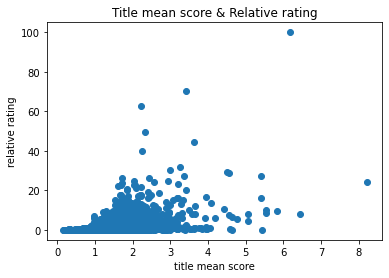

In [12]:
# visualize the processed features and labels
figure = plt.figure()

axis = figure.add_subplot(1, 1, 1) #add an axes object to the figure

axis.scatter(X_all,Y_all) # draw scatterplot based on the two vectors 
axis.set_xlabel('title mean score') # graph label for X
axis.set_ylabel('relative rating') # graph label for Y
axis.set_title('Title mean score & Relative rating')

plt.show()

Some observations, we can see that there are some corelation between the title score we calculated and the relative rating. However, our data contain a few outliers. These are mainly videos that are unusually popular or trendy due to the YouTube algorithm. It is still unclear to the public how the YouTube algorithm works, it sometimes make seemingly "random" suggestion and views on that video will sky rocketed. As we are not intended to make sense of the YouTube algorithm in this report, one valid way according to the course for dealing with these outliers is to remove them from the data set. Since there are only a few outliers, removing them will not have a large effect on the general representation of the data set.

We can see from the plot that the majority of our data has features and labels in the interval 0 $\leq$ X $\leq$ 4, and 0 $\leq$ Y $\leq$ 20.

Therefore, we can use this fact to our advantage and filter out the points that fall outside these ranges. This would still leave us with a large amount of data that we can use for training and testing.

In [13]:
# First, we need to zip the two vectors into a single list of tuples
# that represent points (Xi,Yi)
points = list(zip(X_all,Y_all))

# Then, we filter out all points 
# that have X > 4 or Y > 20
no_outlrs_points =  filter(lambda point: (point[0] > 4 or point[1] > 20) == False, points)

# Next, we can split the filtered points into two X and Y vectors again
unzipped_points = list(zip(*no_outlrs_points))
X_list = list(unzipped_points[0])
Y_list = list(unzipped_points[1])
X = np.array(X_list).reshape(len(X_list),1)
Y = np.array(Y_list)

# print out the shape of X and Y vector to check
print("the shape of the feature matrix is: ",X.shape)
print('the shape of the label vector is: ',Y.shape)

the shape of the feature matrix is:  (4932, 1)
the shape of the label vector is:  (4932,)


The number of datapoints is 4932, which is approximately 99% of the data. Thus, this new X and Y vectors is still a good representation of the original data set.

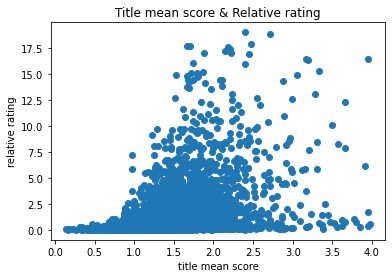

In [14]:
# plot the points again
figure = plt.figure()

axis = figure.add_subplot(1, 1, 1) #add an axes object to the figure

axis.scatter(X,Y) # draw scatterplot based on the two vectors 
axis.set_xlabel('title mean score') # graph label for X
axis.set_ylabel('relative rating') # graph label for Y
axis.set_title('Title mean score & Relative rating')

plt.show()

With the outliers removed and the graph zoomed in, we can see that the correlation between X and Y seem to be more clear.

# Applying Machine Learning methods

   As we are trying to predict a variable that is dependent on another variable (title mean score and relative rating), this is a suitable problem for Regression models. In further details, one could even see that the label tends to increase exponentially as the feature increases. Given this relationship between features and labels, we ought to use Polynomial Regression in order to solve our given problem. Which leave one final problem that need to be solved: identifying the optimal Polynomial degree for our problem. We can find the optimal model by trying out a wide range of Polynomial degrees. This will ensure that we do not miss any potential candidates for our optimal model position and thus obtain the best model for the problem. Hence, the models that will be examine in this report are 2nd degree, 3rd degree, 5th degree, and 8th degree Polynomial Regressions.

We will make use of K-fold to estimate the model's validation error more accurately, as it ensure each data point will be included in the validation set once.

In [15]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

Firstly, 10% of the data must be reserve for the test set.

In [16]:
# reserve 10% of the data for testing first

# split into the test set and the remaining set
X_rem, X_test, Y_rem, Y_test = train_test_split(X,Y,test_size=0.1,random_state=50)

Next, we performs K-fold for all the Polynomial degrees to find the optimal model.

In [17]:
k = 5
k_fold = KFold(n_splits=k, shuffle=True, random_state=50)

In [18]:
### some code lines that is use for plotting in stage 2 of the project are commented out

# plt.figure(figsize=(50, 20))

degrees = [2, 3, 5, 8]

avg_train_errs = []
avg_val_errs = []

# iterate through all the degrees
for i, degree in enumerate(degrees):
    deg_train_errs = []
    deg_val_errs = []

    # plot_row = 0# to keep track of the plot row
    # plot_col = 0
    

    # iterate through all the folds
    for j, (train_indices, val_indices) in enumerate(k_fold.split(X_rem)):
        # make it so that it move on to the next line after every 2 plots
#         if (j % 2 == 0 and j != 0):
#             plot_row += 1
#             plot_col = 0

#         plt.subplot(3, k, plot_row * k + plot_col + 1)   # choose the subplot's location
#         plot_col += 1

        X_train, Y_train, X_val, Y_val = X_rem[train_indices], Y_rem[train_indices], X_rem[val_indices], Y_rem[val_indices]

        # fit the linear model
        regr = LinearRegression(fit_intercept=False)
        polyFeatures = PolynomialFeatures(degree=degree)
        X_train_poly = polyFeatures.fit_transform(X_train)
        regr.fit(X_train_poly, Y_train)


        # Calculate the training and validation error from the current fold
        Y_pred_train = regr.predict(X_train_poly)    # predict using the regression model
        tr_error = mean_squared_error(Y_train, Y_pred_train)    # calculate the training error
        X_val_poly = polyFeatures.transform(X_val)
        Y_pred_val = regr.predict(X_val_poly) # predict labels for the validation data using the regression model 
        val_error = mean_squared_error(Y_val, Y_pred_val) # calculate the validation error

        deg_train_errs.append(tr_error)
        deg_val_errs.append(val_error)
        # plot the current fold
    #     X_fit = np.linspace(0, 4.5, 100)    # generate X interval for the graph, from 0 to 4.5 with 100 samples
    #     plt.tight_layout()
    #     plt.plot(X_val, Y_pred_val, label="Model")    # draw the linear regression model
    #     plt.scatter(X_train, Y_train, color="b", s=10, label="Train Datapoints")    # draw points for train data
    #     plt.scatter(X_val, Y_val, color="r", s=10, label="Validation Datapoints")    # draw points for validation data
    #     plt.xlabel('title mean score')    # set the label for the x/y-axis
    #     plt.ylabel('relative rating')
    #     plt.legend(loc="best")    # set the location of the legend
    #     plt.title(f'CV iteration = {j}\nTraining error = {tr_error:.6}\nValidation error = {val_error:.6}')
    
    
    # calculate the average training and validation error for the current degree, accross all fold
    avg_train_err = np.mean(deg_train_errs)
    avg_val_err = np.mean(deg_val_errs)
    
    avg_train_errs.append(avg_train_err)
    avg_val_errs.append(avg_val_err)
    
# plt.show()

Let's print out the training and validation errors of all the different degree Polynomial models.

In [19]:
for i, degree in enumerate(degrees):
    print(f"""For degree {degree}, average training error = {avg_train_errs[i]:.6f}
    average validation error = {avg_val_errs[i]:.6f}\n""")

For degree 2, average training error = 4.226235
    average validation error = 4.237403

For degree 3, average training error = 4.191956
    average validation error = 4.220556

For degree 5, average training error = 4.187900
    average validation error = 4.239863

For degree 8, average training error = 4.184781
    average validation error = 4.265005



According to the average validation errors, 3rd degree Polynomial model provide the best prediction. For a quick visualization, let's plot this Polynomial implementation throughout all the K-fold iterations.

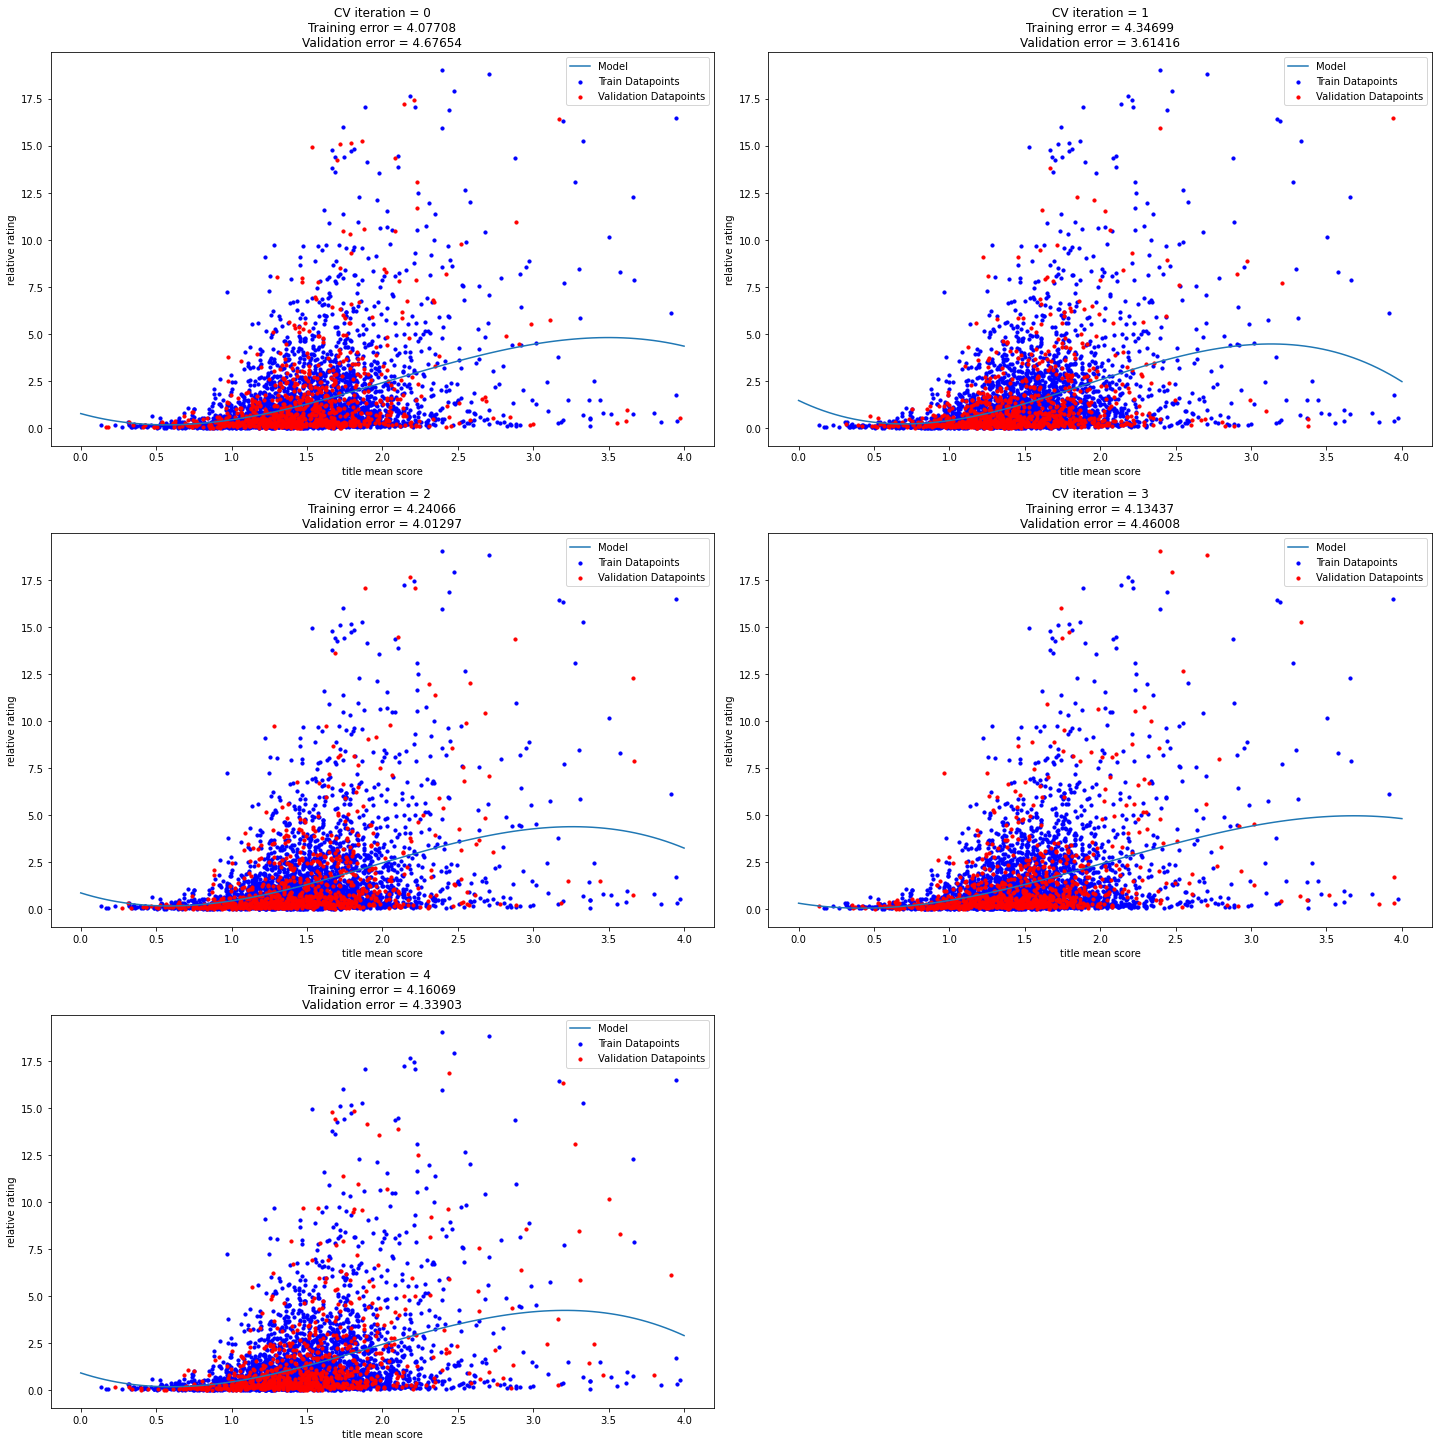

In [20]:
plt.figure(figsize=(50, 20))


plot_row = 0# to keep track of the plot row
plot_col = 0
    

# iterate through all the folds
for j, (train_indices, val_indices) in enumerate(k_fold.split(X_rem)):
    # make it so that it move on to the next line after every 2 plots
    if (j % 2 == 0 and j != 0):
        plot_row += 1
        plot_col = 0

    plt.subplot(3, k, plot_row * k + plot_col + 1)   # choose the subplot's location
    plot_col += 1

    X_train, Y_train, X_val, Y_val = X_rem[train_indices], Y_rem[train_indices], X_rem[val_indices], Y_rem[val_indices]

    # fit the model
    regr = LinearRegression(fit_intercept=False)
    polyFeatures = PolynomialFeatures(degree=3)# make it a third degree model
    X_train_poly = polyFeatures.fit_transform(X_train)
    regr.fit(X_train_poly, Y_train)


    # Calculate the training and validation error from the current fold
    Y_pred_train = regr.predict(X_train_poly)    # predict using the regression model
    tr_error = mean_squared_error(Y_train, Y_pred_train)    # calculate the training error
    X_val_poly = polyFeatures.transform(X_val)
    Y_pred_val = regr.predict(X_val_poly) # predict labels for the validation data using the regression model 
    val_error = mean_squared_error(Y_val, Y_pred_val) # calculate the validation error

    # plot the current fold
    X_fit = np.linspace(0, 4, 100)    # generate X interval for the graph, from 0 to 4.5 with 100 samples
    plt.tight_layout()
    plt.plot(X_fit, regr.predict(polyFeatures.transform(X_fit.reshape(-1, 1))), label="Model")
    plt.scatter(X_train, Y_train, color="b", s=10, label="Train Datapoints")    # draw points for train data
    plt.scatter(X_val, Y_val, color="r", s=10, label="Validation Datapoints")    # draw points for validation data
    plt.xlabel('title mean score')    # set the label for the x/y-axis
    plt.ylabel('relative rating')
    plt.legend(loc="best")    # set the location of the legend
    plt.title(f'CV iteration = {j}\nTraining error = {tr_error:.6}\nValidation error = {val_error:.6}')

    
plt.show()

Now that we have the plots, we can observe that the result is quite interesting. It seems like there is a point of diminishing return when the tile mean score reaches 3.2. 

This is rather unusual since according to common logic, using a title with higher score should give a higher relative rating. What is so special about the 3.2 mark that make the relative rating took a down turn? One possible theory is that there are not enough data points in that region for the model to properly learn from. Since high-viewed videos are far rarer than low-viewed ones, low-viewed videos have higher probability to appear than their high-viewed counterpart. This causes a sampling error to arise, meaning that given a small sample size, the sample is unlikely to accurately represent the whole population. 

   It is known that the larger the sample size, the better representation it is for the population. Therefore, the sampling error is often negated if a large amount of data points is present, as seen in the middle region of the plot where the model performs well. However, when the data is scarce, similar to the rightmost region beyond the 3.2 mark, it is highly likely that the sample will fail to reflect the true nature of the total population.

Finally, to wrap up the project, let's test the chosen model on the test set and obtain the final test error.

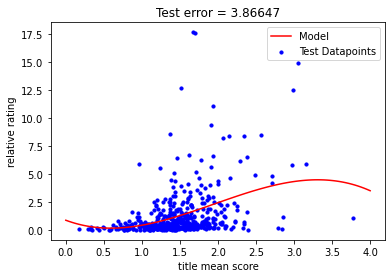

In [21]:
# fit the model using the remaining data (the 90% data that we already seen)
regr = LinearRegression(fit_intercept=False)
polyFeatures = PolynomialFeatures(degree=3)# make it a third degree model
X_rem_poly = polyFeatures.fit_transform(X_rem)
regr.fit(X_rem_poly, Y_rem)

# Calculate the test error using the test set (the 10% unseen data)
X_test_poly = polyFeatures.transform(X_test)
Y_pred_test = regr.predict(X_test_poly)    # predict using the regression model
test_error = mean_squared_error(Y_test, Y_pred_test)    # calculate the training error

# plot the current fold
X_fit = np.linspace(0, 4, 100)    # generate X interval for the graph, from 0 to 4.5 with 100 samples
plt.tight_layout()
plt.plot(X_fit, regr.predict(polyFeatures.transform(X_fit.reshape(-1, 1))), label="Model", color="r")
plt.scatter(X_test, Y_test, color="b", s=10, label="Test Datapoints")    # draw points for train data
plt.xlabel('title mean score')    # set the label for the x/y-axis
plt.ylabel('relative rating')
plt.legend(loc="best")    # set the location of the legend
plt.title(f'Test error = {test_error:.6}')

plt.show()

The model seems quite consistent with our training and validation process. It is worth noting that the test error is even lower than the validation error we had earlier. However, this can again be explain by the fact that our model is not very accurate from the point 3.2 onwards due to the lack of data. Thus, with the test set being randomly sampled and as we can see in the plot, this sample happen to include very few data from the rightward region. Therefore, it is normal that the model give a better result on this specific sample.